In [3]:
import torch

path = "loss_sums_and_counts_per_timestep.pt"
with open(path, 'rb') as f:
    data = torch.load(f)
    
    

In [25]:
from utils.unet_utils import enforce_zero_terminal_snr
from diffusers import DDPMScheduler
from train import get_training_noise_scheduler
from loss import  compute_snr
def plot_snr_weight(gamma, v_pred, ztsnr=True):
    scheduler_config = {
              "_class_name": "DDIMScheduler",
              "_diffusers_version": "0.8.0",
              "beta_end": 0.012,
              "beta_schedule": "scaled_linear",
              "beta_start": 0.00085,
              "clip_sample": False,
              "num_train_timesteps": 1000,
              "prediction_type": "v_prediction",
              "set_alpha_to_one": False,
              "skip_prk_steps": True,
              "steps_offset": 1,
              "trained_betas": None
            }
    noise_scheduler = DDPMScheduler.from_config(scheduler_config)
    if ztsnr:
        ztsnr_betas = enforce_zero_terminal_snr(noise_scheduler.betas).numpy().tolist()
        scheduler_config_ztsnr = dict(scheduler_config)
        scheduler_config_ztsnr.update({'trained_betas': ztsnr_betas})
        noise_scheduler = DDPMScheduler.from_config(scheduler_config_ztsnr)
    timesteps = torch.arange(0, 1000)
    print(timesteps[-1])
    snr = compute_snr(timesteps, noise_scheduler, max_sigma=22000)
    min_snr_gamma = torch.minimum(snr, torch.full_like(snr, gamma))
    if v_pred:
        weights = min_snr_gamma / (snr + 1)
    else:
        weights =  min_snr_gamma / snr
    #weights /= weights.max()
    weights += 0.0047
    #print(weights)
    plt.plot(weights)
    return weights


tensor(999)


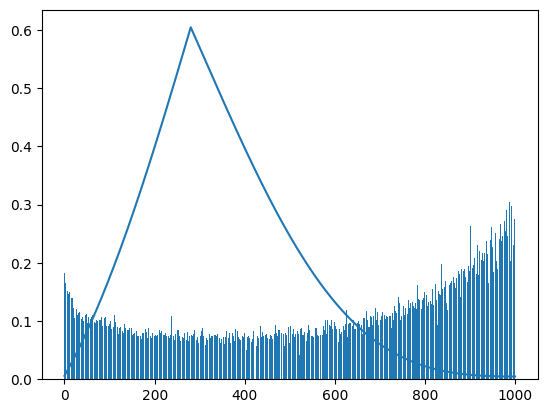

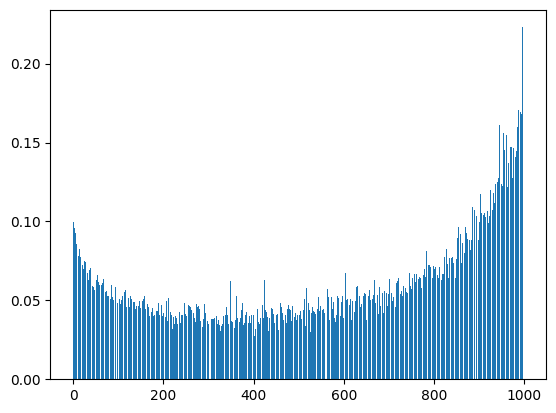

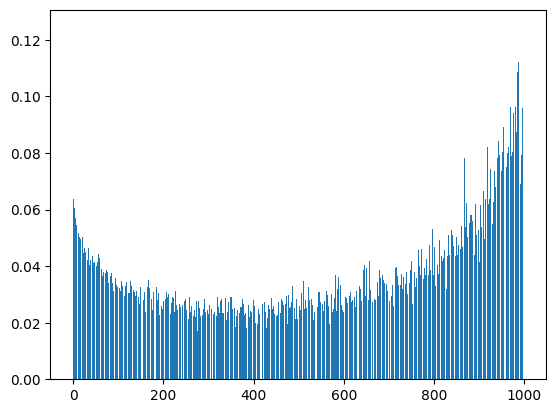

In [29]:
import matplotlib.pyplot as plt
weights = plot_snr_weight(gamma=1.5, v_pred=True, ztsnr=True)
for res in data.keys():
    values: torch.Tensor = data[res]
    plt.bar(range(len(values)-1), height=values[:-1]/weights)
    plt.show()

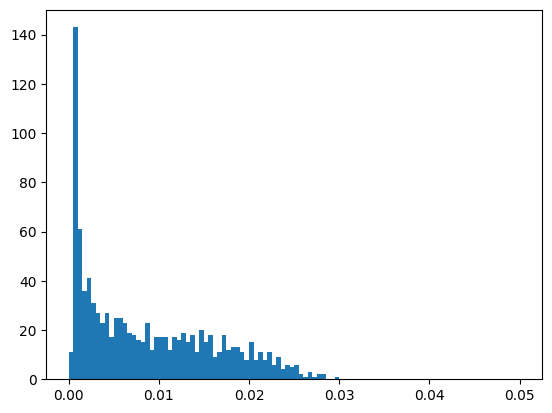

In [19]:
plt.hist(data[1024], bins=100, range=(0, 0.05))
plt.show()

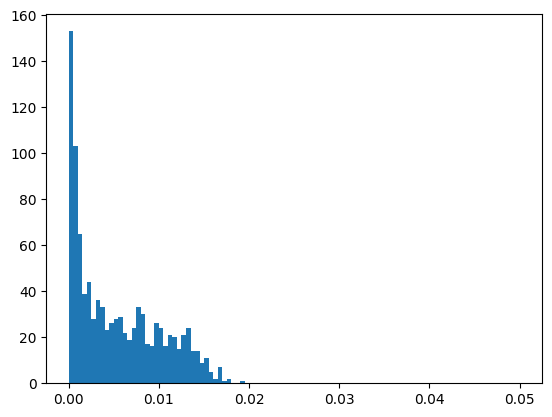

In [20]:
plt.hist(data[1280], bins=100, range=(0, 0.05))
plt.show()